# EDA and Modelling



### We have succesfully scraped a reasonably sized corpus from 2 subreddits: Stocks and Real Estate investments and will proceed to clean up the corpus before modelling


[Recap on how we scrapped the data](01_Data_collection.ipynb)

In [31]:
# import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import libraries for text cleaning
import regex as re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# import libraries for feature engineering and model creation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, matthews_corrcoef

# import library to output our model 
import pickle

In [2]:
# import dataset

rawtext = pd.read_csv('data/final.csv')
rawtext.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
rawtext.head(15)
rawtext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1253 non-null   int64 
 1   rawtext    1248 non-null   object
dtypes: int64(1), object(1)
memory usage: 19.7+ KB


## Data cleaning

In [3]:
# create a function to clean up the rawtext of non-word characters and digits

def cleaning_str(string):
    new_1 = re.sub('(http://.*?\s)|(http://.*)',' ',str(string))
    new_2 = re.sub('[.*_]','',new_1)
    new_3 = re.sub('\d','',new_2)
    new_4 = re.sub('\W',' ',new_3)
    return new_4

rawtext['cltext'] = rawtext['rawtext'].apply(cleaning_str)


In [4]:
# create a function to lemmatise the text by the various POS

lem = WordNetLemmatizer()

def lemmer(line):
    bagW = []
    liner = line.lower().split()
    for word in liner:
        a = lem.lemmatize(word, "v")
        b = lem.lemmatize(a, "n")
        c = lem.lemmatize(b, "r")
        d = lem.lemmatize(c, "a")
        bagW.append(d)
    
    return " ".join(bagW)



rawtext['ltext'] = rawtext['cltext'].apply(lemmer)

## EDA

In [5]:
rawtext.info()
rawtext.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1253 non-null   int64 
 1   rawtext    1248 non-null   object
 2   cltext     1253 non-null   object
 3   ltext      1253 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.3+ KB


,subreddit,rawtext,cltext,ltext
0,1,Please use this thread to discuss your portfol...,Please use this thread to discuss your portfol...,please use this thread to discus your portfoli...
1,1,"This is the daily discussion, so anything stoc...",This is the daily discussion so anything stoc...,this be the daily discussion so anything stock...
2,1,It shall be interesting to see how the market ...,It shall be interesting to see how the market ...,it shall be interest to see how the market rea...
3,1,Zoom has added close to **$40 billion** to its...,Zoom has added close to billion to its marke...,zoom have add close to billion to it market ca...
4,1,\n- TSLA: up more than 10x in the past 12 mont...,TSLA up more than x in the past months ...,tsla up more than x in the past month nvda up ...


In [6]:
for line in rawtext.ltext[124:125]:
    print(line)
    
print("\n\n")

for line in rawtext.cltext[124:125]:
    print(line)

hey guy i m new to stock market i ve just start study macro micro along with trade i just want to understand what do it mean to predict the movement of a stock index of country let s say a use the close point of stock index of a country b and how can one do so with very basic knowledge it s actually a part of pre commencement activity in my under grad in capital market how do i do that i m completely clueless



Hey guys I m new to stock market I ve just started studying macro micro along with trading   I just wanted to understand what does it mean to predict the movement of a stock index of country let s say A using the closing point of stock index of a country B and how can one do so with very basic knowledge  It s actually a part of pre commencement activities in my under grad in capital markets How do I do that  I m completely clueless


####  We can observe that the lemmatisation has succefully parsed the data to its root words

In [7]:
# clean up any  null rows
rawtext.dropna(axis=0, inplace=True)
rawtext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1248 entries, 0 to 1252
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  1248 non-null   int64 
 1   rawtext    1248 non-null   object
 2   cltext     1248 non-null   object
 3   ltext      1248 non-null   object
dtypes: int64(1), object(3)
memory usage: 48.8+ KB


#### As we had cleaned the dataset earlier, we can observe an almost equal distribution of the 2 categories.
Our Baseline Score that our model needs to beat, would be **50.5%**

In [8]:
# final category counts: 1 - Finance, 0 - Real Estate
print(rawtext.subreddit.value_counts())
print(rawtext.subreddit.value_counts(normalize=True))

1    630
0    618
Name: subreddit, dtype: int64
1    0.504808
0    0.495192
Name: subreddit, dtype: float64


In [9]:
# create specific stopwords for our usecase

stopw = CountVectorizer(stop_words = 'english').get_stop_words()
my_stopwords = [word for word in stopw]
len(my_stopwords)

# Based on the 2 themes, we would logically observe a high frequency of certain words and 
# they should be removed to not bias the model before further EDA on the corpus.
my_stopwords.extend(['stocks', 'stock', 'real','estate', 'property', 'invest', 'investing', 'investment', 'properties'])
len(my_stopwords)


327

In [10]:
# Investigate word freq to further reduce model noise
cvec = CountVectorizer(max_features=1200,stop_words=my_stopwords)
cvec.fit(rawtext['ltext'])

all_features = pd.DataFrame(cvec.transform(rawtext['ltext']).todense(),
                       columns=cvec.get_feature_names())

labels = rawtext['subreddit']

joined = pd.concat([all_features,labels], axis=1)

features1 = joined[joined.subreddit==1].sum(axis=0)
print ("TOP 30 WORDS in Stocks category")
print ("--" * 30)
cw1 = features1.sort_values(ascending = False).head(30)
print (cw1)

print("\n\n")

features0 = joined[joined.subreddit==0].sum(axis=0)
print ("TOP 25 WORDS in RealEstate category")
print ("--" * 30)
cw0 = features0.sort_values(ascending = False).head(30)
print (cw0)


TOP 30 WORDS in Stocks category
------------------------------------------------------------
subreddit    630.0
market       399.0
company      367.0
buy          358.0
http         348.0
share        346.0
year         297.0
amp          273.0
just         271.0
price        269.0
like         244.0
trade        219.0
think        211.0
sell         209.0
earn         206.0
make         201.0
time         197.0
new          194.0
look         182.0
know         178.0
day          161.0
high         156.0
say          154.0
tesla        153.0
long         148.0
hold         148.0
good         147.0
split        145.0
gt           139.0
use          135.0
dtype: float64



TOP 25 WORDS in RealEstate category
------------------------------------------------------------
rent        456.0
house       435.0
buy         415.0
year        404.0
home        396.0
look        374.0
like        313.0
just        295.0
want        280.0
rental      254.0
make        247.0
ve          243.0
mortga

We can observe a few words that could potentially add noise during modelling; that are found either in high frequency and in both datasets or have no meaning to the topics on hand.
Let's update the stopwords and observe the top words again.

In [11]:
a_set = set(cw0.index) 
b_set = set(cw1.index) 
  
if (a_set & b_set): 
    common = list(a_set & b_set)
    print(common) 
else: 
    print("No common elements") 
    
my_stopwords.extend(common)
my_stopwords.extend(['ve', 'amp', 'gt','don', 'http'])
print(len(my_stopwords))

['time', 'look', 'make', 'like', 'use', 'market', 'good', 'buy', 'just', 'new', 'know', 'year']
344


In [12]:
cvec = CountVectorizer(max_features=1200,stop_words=my_stopwords)
cvec.fit(rawtext['ltext'])

updated_features = pd.DataFrame(cvec.transform(rawtext['ltext']).todense(),
                       columns=cvec.get_feature_names())

labels = rawtext['subreddit']

new_joined = pd.concat([updated_features,labels], axis=1)

features1 = new_joined[new_joined.subreddit==1].sum(axis=0)
# to remove the subreddit column boolean value
features1 = features1.drop('subreddit', axis=0)
print ("TOP 30 WORDS in Stocks category")
print ("--" * 30)
cw1 = features1.sort_values(ascending = False).head(30)
print (cw1)

print("\n\n")

features0 = new_joined[new_joined.subreddit==0].sum(axis=0)
print ("TOP 30 WORDS in RealEstate category")
print ("--" * 30)
cw0 = features0.sort_values(ascending = False).head(30)
print (cw0)

TOP 30 WORDS in Stocks category
------------------------------------------------------------
company      367.0
share        346.0
price        269.0
trade        219.0
think        211.0
sell         209.0
earn         206.0
day          161.0
high         156.0
say          154.0
tesla        153.0
long         148.0
hold         148.0
split        145.0
walmart      131.0
term         130.0
want         127.0
news         121.0
etf          117.0
money        116.0
text         115.0
month        113.0
start        112.0
portfolio    111.0
week         104.0
thank        103.0
apple        102.0
option       101.0
today         97.0
people        94.0
dtype: float64



TOP 30 WORDS in RealEstate category
------------------------------------------------------------
rent        456.0
house       435.0
home        396.0
want        280.0
rental      254.0
mortgage    233.0
cash        231.0
area        220.0
pay         216.0
live        214.0
month       213.0
loan        198.0
unit  

#### We could perpetually continue this process but lose crucial deterministic vocabulary. At this stage, it looks good enough! Let's proceed with creating our pipelines and then to model

## Modelling

In [13]:
# create pipelines for each permutation of 2 transformers and 3 estimators

pipe_1 = Pipeline([('cv', CountVectorizer(stop_words=my_stopwords)), ('lr', LogisticRegression(random_state=42))])
pipe_2 = Pipeline([('tf', TfidfVectorizer(stop_words=my_stopwords)), ('lr', LogisticRegression(random_state=42))])
pipe_3 = Pipeline([('cv', CountVectorizer(stop_words=my_stopwords)), ('nb', MultinomialNB())])
pipe_4 = Pipeline([('tf', TfidfVectorizer(stop_words=my_stopwords)), ('nb', MultinomialNB())])
pipe_5 = Pipeline([('cv', CountVectorizer(stop_words=my_stopwords)), ('svc', SVC(random_state=42))])
pipe_6 = Pipeline([('tf', TfidfVectorizer(stop_words=my_stopwords)), ('svc', SVC(random_state=42))])


In [14]:
# define X (lemmatized text) and y 
X = rawtext[['ltext']]
y = rawtext['subreddit']

In [15]:
# train test split with a y-stratify (just to remove any class bias, however minimal)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2,
                                                    stratify=y)
X_train.shape, X_test.shape

((998, 1), (250, 1))

# Running models on default hyperparams


------------------------------------------------------------
Training Pipeline 1 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 1: 1.0
Test score for pipeline 1: 0.944

Confusion Matrix for pipeline 1:


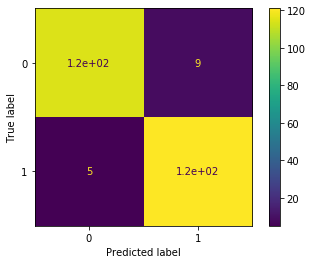

True Negatives: 115
False Positives: 9
False Negatives: 5
True Positives: 121

Matthews Correlation Coeff. for pipeline 1: 0.8884
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 2 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 2: 0.9909819639278558
Test score for pipeline 2: 0.948

Confusion Matrix for pipeline 2:


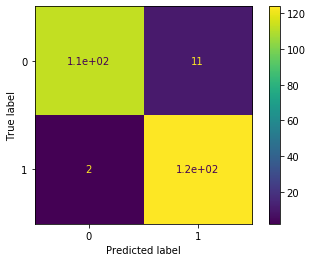

True Negatives: 113
False Positives: 11
False Negatives: 2
True Positives: 124

Matthews Correlation Coeff. for pipeline 2: 0.8983
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 3 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 3: 0.9859719438877755
Test score for pipeline 3: 0.948

Confusion Matrix for pipeline 3:


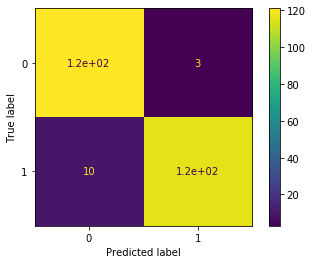

True Negatives: 121
False Positives: 3
False Negatives: 10
True Positives: 116

Matthews Correlation Coeff. for pipeline 3: 0.8974
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 4 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 4: 0.9899799599198397
Test score for pipeline 4: 0.96

Confusion Matrix for pipeline 4:


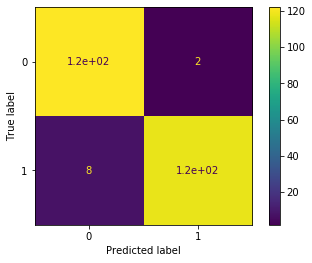

True Negatives: 122
False Positives: 2
False Negatives: 8
True Positives: 118

Matthews Correlation Coeff. for pipeline 4: 0.9211
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 5 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 5: 0.9719438877755511
Test score for pipeline 5: 0.924

Confusion Matrix for pipeline 5:


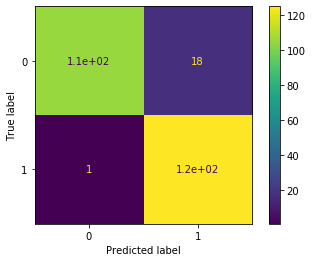

True Negatives: 106
False Positives: 18
False Negatives: 1
True Positives: 125

Matthews Correlation Coeff. for pipeline 5: 0.8558
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 6 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 6: 1.0
Test score for pipeline 6: 0.948

Confusion Matrix for pipeline 6:


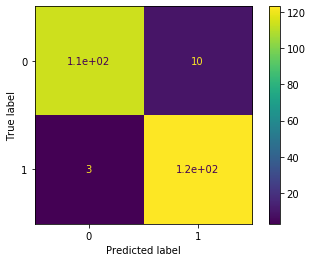

True Negatives: 114
False Positives: 10
False Negatives: 3
True Positives: 123

Matthews Correlation Coeff. for pipeline 6: 0.8974
------------------------------------------------------------ 





In [16]:
# loop to run all 6 pipelines

pipeline_list = [pipe_1, pipe_2, pipe_3, pipe_4, pipe_5, pipe_6]
for num, pipeline in enumerate(pipeline_list):
    pipeline.fit(X_train['ltext'], y_train)
    print("---"*20)
    print(f"Training Pipeline {num+1} on default settings using {len(pipeline.steps[0][1].vocabulary_)} words.")
    print("---"*20,"\n")
    
    print(f"Train score for pipeline {num+1}: {pipeline.score(X_train['ltext'],y_train)}")
    print(f"Test score for pipeline {num+1}: {pipeline.score(X_test['ltext'],y_test)}")
    
    
    y_pred = pipeline.predict(X_test['ltext'])


    print(f"\nConfusion Matrix for pipeline {num+1}:")
    plt.show(plot_confusion_matrix(pipeline, X_test['ltext'],y_test))


    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    
    print(f"\nMatthews Correlation Coeff. for pipeline {num+1}: {round(matthews_corrcoef(y_test,y_pred),4)}")
   
    
    print("---"*20,"\n\n\n")
    
    

### Observations:

The accuracy scores between our train/test sets don't indicate a huge overfit issues and at the same time, they don't provide much information  In our business case, the most important metric to evaluate the model predicting a binary outcome, would be the Matthews Correlation Coefficient. The MCC takes into the account the misclassfication rate between the classes and returns a score of 1 or -1 for a perfectly/imperfectly classfication. If the score nears 0, the model prediction would be no better than random chance. 

Here's how the MCC is calculated:
    ![](https://miro.medium.com/max/700/1*8E2rPn_ccOqGuPYj1gBTAg.png)
       

Based on the default parameters, we can observe that our 4th pipeline, running a TF-IDF vectoriser and Naive Bayes Classifier, had the lowest number of misclassified posts. Two of the real estate posts were missclasified as finance, versus five finance posts were misclassified as real estate.


**Let's now explore how the results change as we use GridsearchCV to pick out the best hyperparameters**


# Running models after finetuning hyperparams


In [17]:
# create pipe params dict for each pipe
      

pipe_1_params= {'cv__ngram_range': [(1,1), (1,2),(2,2)],
                'cv__min_df' : [2,3,5],
                'cv__max_df': [0.85,0.95],
                'lr__C': [1.0, 5.0, 10.0],
                
                    
}

pipe_2_params= {'tf__ngram_range': [(1,1), (1,2), (2,2)],
                'tf__min_df' : [2,3,5],
                'tf__max_df': [0.85,0.95],
                'lr__C': [1.0, 5.0, 10.0],
             
}


pipe_3_params= {'cv__ngram_range': [(1,1), (1,2), (2,2)],
                'cv__min_df' : [2,3,5],
                'cv__max_df': [0.85,0.95],
                'nb__alpha': [1.0, 0.5, 0.1, 0.05]              
}


pipe_4_params= {'tf__ngram_range': [(1,1), (1,2),(2,2)],
                'tf__min_df' : [2,3,5],
                'tf__max_df': [0.85,0.95],
                'nb__alpha': [1.0, 0.5, 0.1, 0.05]              
}



pipe_5_params= {'cv__ngram_range': [(1,1), (1,2), (2,2)],
                'cv__min_df' : [2,3,5],
                'cv__max_df': [0.85,0.95],
                'svc__C': [1.0, 5.0,10.0,15.0],  
}


pipe_6_params= {'tf__ngram_range': [(1,1), (1,2), (2,2)],
                'tf__min_df' : [2,3,5],
                'tf__max_df': [0.85,0.95],
                'svc__C': [1.0,5.0,10.0,15.0],

}


------------------------------------------------------------
Training Pipeline 1 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 1: 1.0
Test score for pipeline 1: 0.9891833077316948
Best parameters for pipeline 1: {'cv__max_df': 0.85, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'lr__C': 1.0}

Confusion Matrix for pipeline 1:


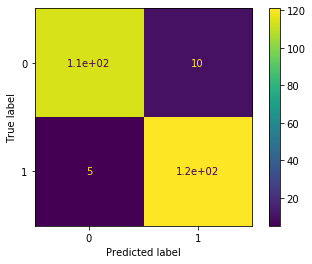

True Negatives: 114
False Positives: 10
False Negatives: 5
True Positives: 121

Matthews Correlation Coeff. for pipeline 1: 0.8807
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 2 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 2: 0.9999759012916908
Test score for pipeline 2: 0.9947516641065028
Best parameters for pipeline 2: {'lr__C': 1.0, 'tf__max_df': 0.85, 'tf__min_df': 2, 'tf__ngram_range': (1, 2)}

Confusion Matrix for pipeline 2:


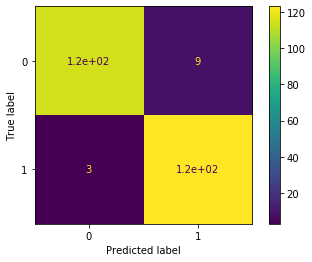

True Negatives: 115
False Positives: 9
False Negatives: 3
True Positives: 123

Matthews Correlation Coeff. for pipeline 2: 0.905
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 3 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 3: 0.9983934194460511
Test score for pipeline 3: 0.9917434715821813
Best parameters for pipeline 3: {'cv__max_df': 0.85, 'cv__min_df': 3, 'cv__ngram_range': (1, 2), 'nb__alpha': 1.0}

Confusion Matrix for pipeline 3:


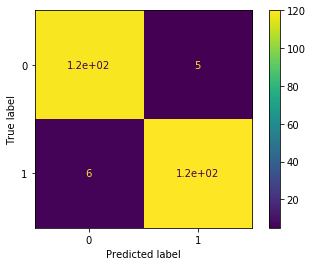

True Negatives: 119
False Positives: 5
False Negatives: 6
True Positives: 120

Matthews Correlation Coeff. for pipeline 3: 0.912
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 4 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 4: 0.9997308977572135
Test score for pipeline 4: 0.9951356886840759
Best parameters for pipeline 4: {'nb__alpha': 0.5, 'tf__max_df': 0.85, 'tf__min_df': 3, 'tf__ngram_range': (1, 2)}

Confusion Matrix for pipeline 4:


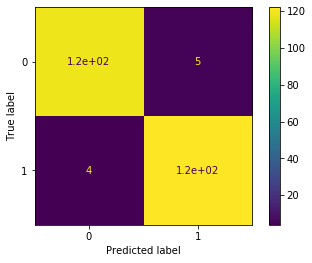

True Negatives: 119
False Positives: 5
False Negatives: 4
True Positives: 122

Matthews Correlation Coeff. for pipeline 4: 0.928
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 5 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 5: 0.9994698284171969
Test score for pipeline 5: 0.9864311315924219
Best parameters for pipeline 5: {'cv__max_df': 0.85, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'svc__C': 1.0}

Confusion Matrix for pipeline 5:


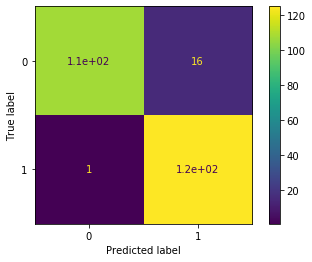

True Negatives: 108
False Positives: 16
False Negatives: 1
True Positives: 125

Matthews Correlation Coeff. for pipeline 5: 0.8702
------------------------------------------------------------ 



------------------------------------------------------------
Training Pipeline 6 on default settings using 6285 words.
------------------------------------------------------------ 

Train score for pipeline 6: 1.0
Test score for pipeline 6: 0.9925755248335894
Best parameters for pipeline 6: {'svc__C': 1.0, 'tf__max_df': 0.85, 'tf__min_df': 2, 'tf__ngram_range': (1, 2)}

Confusion Matrix for pipeline 6:


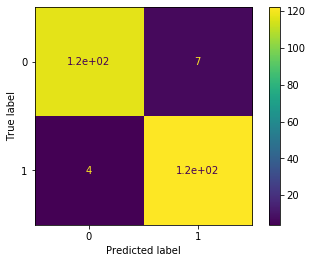

True Negatives: 117
False Positives: 7
False Negatives: 4
True Positives: 122

Matthews Correlation Coeff. for pipeline 6: 0.9122
------------------------------------------------------------ 





In [18]:
# running Gridsearch with tuned hyperparameters on all 6 pipelines

pipeline_list = [pipe_1, pipe_2, pipe_3, pipe_4, pipe_5, pipe_6]
pipe_params_list = [pipe_1_params, pipe_2_params, pipe_3_params, pipe_4_params, pipe_5_params, pipe_6_params]

for num, pipeline in enumerate(pipeline_list):
    pipeline.fit(X_train['ltext'], y_train)
    print("---"*20)
    print(f"Training Pipeline {num+1} on default settings using {len(pipeline.steps[0][1].vocabulary_)} words.")
    print("---"*20,"\n")
    
    gs = GridSearchCV(pipeline, param_grid=pipe_params_list[num], cv=10, scoring='roc_auc')
    gs.fit(X_train['ltext'], y_train)
    print(f"Train score for pipeline {num+1}: {gs.score(X_train['ltext'],y_train)}")
    print(f"Test score for pipeline {num+1}: {gs.score(X_test['ltext'],y_test)}")
    print(f"Best parameters for pipeline {num+1}: {gs.best_params_}")
    
    
    y_pred = gs.predict(X_test['ltext'])


    print(f"\nConfusion Matrix for pipeline {num+1}:")
    plt.show(plot_confusion_matrix(gs, X_test['ltext'],y_test))


    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    
    print(f"\nMatthews Correlation Coeff. for pipeline {num+1}: {round(matthews_corrcoef(y_test,y_pred),4)}")
   
    
    print("---"*20,"\n\n\n")

### Consolidated model results using default hyperparameters
   Transformer/Classifier|MCC|Misclassified<br /> RealEstate|Misclassified<br /> Stocks|                    
  ------|------|:------:|:----:|   
   CV & Log Reg|0.8883|9|5| 
   TF & Log Reg|0.9050|9|3|
   CV & Multinomial NB|0.8974|3|10 |
   **TF & Multinomial NB**|**0.9211**|**2**|**8**|
   CV & SVC|0.8558|18 |1|
   TF & SVC|0.8974|10|3|



### Consolidated model results after tuning hyperparameters
   
  Transformer/Classifier|MCC|Misclassified<br /> RealEstate|Misclassified<br /> Stocks|                    
  ------|------|:------:|:----:|   
   CV & Log Reg|0.8807|10|5 | 
   TF & Log Reg|0.8983|11|2|
   CV & Multinomial NB|0.9120|5|6 |
   **TF & Multinomial NB**|**0.9280**|**5**|**4**|
   CV & SVC|0.8702|16 |1|
   TF & SVC|0.9122|7|4|                 

#### Final Observations on model results:
Our Multinomial Naive Bayes model using a TF-IDF vectoriser came out tops again, even slightly beating the default parameter model's MCC score. It can also be observed that the TF-IDF models generally had a better MCC score than models using CountVectoriser.

This mainly could be due to the fact that TD-IDF benefits from the lemmatization. Lemmatization is also important for training word vectors, since accurate counts within the window of a word would be disrupted by an irrelevant inflection like a simple plural or present tense inflection. This is also the reason we had lemmatised our corpus across multiple parts-of-speech tags , i.e verb, noun, proverb and adjective.

Based on the MCC scores, we believe the NB model would allow a good measure of generalisation that would perform relatively well on our blind data later on. However for our eventual model of choice, we would be going with the TF-SVC model, which fared a reasonable MCC score.

The key factor that led us to choosing the SVC model is that Naive Bayes treats corpus terms as independent features, whereas SVC looks at the interactions between them to a certain degree. As our blind test might have more variations to the terms gathered from our subreddit, we forsee the SVC model will be better at the classification task, under a production environment.

#### Further up above, we had examined the frequency of words sorted by each class to remove words that might add noise to the model.  Let us now take a closer look at the deterministic words of each category

In [19]:
gs_tf_nb = GridSearchCV(pipe_4, param_grid=pipe_4_params, cv=3, scoring='roc_auc')
gs_tf_nb.fit(X['ltext'],y);

In [20]:
#prob for positive class
pos_class_prob_sorted = gs_tf_nb.best_estimator_.named_steps['nb'].feature_log_prob_[1].argsort()[::-1]
#prob for negative class
neg_class_prob_sorted = gs_tf_nb.best_estimator_.named_steps['nb'].feature_log_prob_[0].argsort()[::-1]
#getting the top features 
neg_top_features = np.take(gs_tf_nb.best_estimator_.named_steps['tf'].get_feature_names(), neg_class_prob_sorted)
pos_top_features = np.take(gs_tf_nb.best_estimator_.named_steps['tf'].get_feature_names(), pos_class_prob_sorted)

In [1]:
print("Here are the TOP 20 words that are deterministic of each class:")
print("***"*20,"\n\n")
print("Stocks Investment")
print("--"*10)
for i in range(20):
    print(pos_top_features[i])
print("\n\n")
print("Real Estate Investment")
print("--"*10)
for i in range(20):
    print(neg_top_features[i])     

Here are the TOP 20 words that are deterministic of each class:
************************************************************ 


Stocks Investment
--------------------


NameError: name 'pos_top_features' is not defined

#### Final Observations:

We notice that a few words in the Stocks category like Apple, Tesla and ETF have been more influential considering their lower occurences in the corpus. We observe very little movement in the order of words under the Real Estate category do to the more frequent occurences of these words.

This poor variance in deterministic terms under the Real Estate Category, could explain the higher rate of misclassification from the test data. 

To solve this issue, we could have substantially increased the number of posts under the real estate category. Taking a peek at the start of our journey, we did start off having 818 posts, so there should be sufficient data for us to improve our model.




## Concept to test out MVP
We haven't reached the end yet we have manually scrapped 20 real life posts(10 for each class) from the Seedly forum to test how our model performs in this blind test.

In [22]:
blind_test = pd.read_csv('data/seedly_test.csv')

In [23]:
blind_test

,subreddit,rawtext
0,0,"Hey guys, i’m 21, currently half way through a..."
1,0,Would you rent out a spare room in the propert...
2,0,"If I have enough to pay off my home loan, shou..."
3,0,Is it a good idea to start stashing savings to...
4,0,Hi Sam! What is your personal view of real est...
5,0,"If you have $30,000. Three options. To put in ..."
6,0,Can HDB apartment be use as bond if parents do...
7,0,Which is a better option if my main aim is to ...
8,0,I recently seen the I Quadrant's advertisement...
9,0,"I’m just curious, as a male in his young 20s w..."


In [48]:
# Load model with best parameters in pipeline and fit with entire corpus
test_pipe = Pipeline([('tf', TfidfVectorizer(max_df=0.85, min_df=3, ngram_range=(1, 2), stop_words=my_stopwords)), 
                      ('svc', SVC(C=1.0))])
test_pipe.fit(X['ltext'],y);

In [49]:
def seedly_classifier(df,raw_col_name):
    #clean text (regex and stopwords)
    cleaned = df[raw_col_name].apply(cleaning_str).apply(lemmer)
    df['ltext'] = cleaned
    
    #predict cleantext with trained pipe
    preds = test_pipe.predict(cleaned)
    
    #return prediction labels
    df['predictions'] = preds
    
    #determine misclassification rate
    print("---"*35)
    print(f"Confusion Matrix for blind test:")
    print("---"*35)
    plt.show(plot_confusion_matrix(test_pipe, df['ltext'], df['subreddit']))


    tn, fp, fn, tp = confusion_matrix(df['subreddit'], preds).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    
    print("---"*35)
    print(f"Matthews Correlation Coeff. for blind test: {round(matthews_corrcoef(df['subreddit'], preds),4)}")
    print("---"*35)
    
    return df

---------------------------------------------------------------------------------------------------------
Confusion Matrix for blind test:
---------------------------------------------------------------------------------------------------------


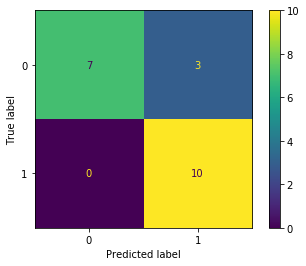

True Negatives: 7
False Positives: 3
False Negatives: 0
True Positives: 10
---------------------------------------------------------------------------------------------------------
Matthews Correlation Coeff. for blind test: 0.7338
---------------------------------------------------------------------------------------------------------


,subreddit,rawtext,ltext,predictions
0,0,"Hey guys, i’m 21, currently half way through a...",hey guy i m currently half way through army co...,0
1,0,Would you rent out a spare room in the propert...,would you rent out a spare room in the propert...,0
2,0,"If I have enough to pay off my home loan, shou...",if i have enough to pay off my home loan shoul...,0
3,0,Is it a good idea to start stashing savings to...,be it a good idea to start stash save to pay d...,0
4,0,Hi Sam! What is your personal view of real est...,hi sam what be your personal view of real esta...,1
5,0,"If you have $30,000. Three options. To put in ...",if you have three option to put in fix deposit...,0
6,0,Can HDB apartment be use as bond if parents do...,can hdb apartment be use a bond if parent do n...,0
7,0,Which is a better option if my main aim is to ...,which be a well option if my main aim be to mi...,0
8,0,I recently seen the I Quadrant's advertisement...,i recently see the i quadrant s advertisement ...,1
9,0,"I’m just curious, as a male in his young 20s w...",i m just curious a a male in his young s with ...,1


In [50]:
seedly_classifier(blind_test,'rawtext')

In [27]:
# Misclassification post 1
print(blind_test.loc[4]['ltext'])

hi sam what be your personal view of real estate re a an asset class and it expect return move forward how much do physical re make up of your own portfolio


In [28]:
# Misclassification post 2
print(blind_test.loc[8]['ltext'])

i recently see the i quadrant s advertisement on facebook where they advertise to help singaporean own property in year with little or no money be it ma approve what be the risk


In [29]:
# Misclassification post 3
print(blind_test.loc[9]['ltext'])

i m just curious a a male in his young s with fulltime job pay k before cpf be there any way to make use of buy and sell property in singapore to earn big buck


# conclusion

We have succesfully built a text classifier model and have throughly evaluated its performance. In our blind test, our SVC model has done tremendously well in the Stocks category, however it has misclassified 3 Real Estate posts.
Zooming into the first misclassification, the word 'portfolio' was a strong determinant of the Stocks category and taking a look at the other 2 posts, there were very few deterministic terms in the text.

There was a mention of the word 'cpf', which would be a term commonly used in Real Estate Investments locally. This underscores the need to provide more deterministic terms by feeding more local forum posts under these 2 classes, to improve the model's local context.

In [47]:
# pickle the model for model demo
# pickle.dump(test_pipe,open('seedly.pkl', 'wb'))